<a href="https://colab.research.google.com/github/Erike-Simon/CESAR-AED/blob/main/TempSeries_atividade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CESAR School Recife**

Disciplina: Séries Temporais

Alunos: *Erike Simon, José Aparecido*

**Atividade 2:** Modelagem de Séries Temporais

* Escolha uma série temporal;
* Aplique o Arima +  2 modelos de aprendizagem de máquina (a sua escolha);
* Realize avaliação de métricas: MSE, MAPE, ... ;
* Criar resumo sobre os resultados.

## Configurações

In [ ]:
pip install pydataset pmdarima tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.1 MB/s eta 0:00:00
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939417 sha256=84c2c64906290af444b77477858a1135bf3cf9aa8cc34eb1ad80664c7ceb99b6
  Stored in directory: /root/.cache/pip/wheels/2b/83/5c/073c3755e8b7704e4677557b2055e61026c1a2342149214c13
Successfully built pydataset


In [ ]:
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm
from google.colab import drive

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

initiated datasets repo at: /root/.pydataset/


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Funções

Funções para cálulo de métricas de desempenho

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):
    return mean_square_error(y_true, y_pred)**0.5

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}

Função para treino e predição de um modelo baseado em auto.arima para uma série temporal

In [ ]:
# Função para treino e predição de um modelo baseado em auto.arima para uma série temporal
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values # pois não se deve incluir o horizonte de previsão
  ts_test = ts[-(test_size+(horizon-1)):].values

  # criando o modelo com o conjunto de treino
  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=10, m=m,
            stepwise=True, trace=True)

  # o predict deve fazer a previsão do mesmo número de linhas (duração de tempo) do conjunto de teste
  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  # A variável 'prevs_h_steps' é uma lista que armazenará as previsões com um horizonte de 'horizon'.
  # O loop 'for' itera sobre o conjunto de teste (ts_test) e a cada iteração, faz uma previsão de 'horizon' períodos à frente.
  # O valor da previsão é armazenado em 'prevs_h_steps' para uso posterior e o modelo é atualizado com o valor real observado (t).
  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1]) # '[horizon-1]' acessa o valor exato do horizonte de previsão desejado.
                                                            # Ocorre porque a função 'model.predict(horizon)' retorna previsões para todos
                                                            # os horizontes e estamos interessados apenas na previsão para o período 'horizon'.

    model.update(t) # Essa linha atualiza o modelo ARIMA com o valor observado 't' no conjunto de teste. Isso é importante porque,
                    # à medida que fazemos previsões passo a passo, queremos que o modelo se ajuste aos dados reais à medida que avançamos no tempo.

  # A função retorna duas séries de previsões: 'prevs_h_steps' que são as previsões com
  # o horizonte especificado e 'direct_predict' que são as previsões diretas. estas duas
  # séries serão comparadas nas celulas posteriores
  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

Funções para diferenciação, treinamento e normalização para os modelos SRV e MLP

In [ ]:
# Função para criação de janela temporal
def create_windowing(df, lag_size):
    final_df = None
    for i in range(0, (lag_size + 1)):
        serie = df.shift(i)
        if (i == 0):
            serie.columns = ['actual']
        else:
            serie.columns = [str('lag' + str(i))]

        final_df = pd.concat([serie, final_df], axis=1)

    return final_df.dropna()

# Função para subtração dos valores
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return pd.Series(diff).values

# voltar a subtração
def inverse_diference(last_ob, value):
  return value + last_ob

# Obtêm a diferença
def get_inverse_diference(last_ob, value):
  return [inverse_diference(last_ob[i], value[i]) for i in range(0, len(value))]

# Função para treino e predição de modelos sklearn
def fit_predict_sklearn(test_size, lag_size, horizon,
                        ts, model, use_diff=False):

  # Condições para diferenciação da série
  if use_diff:
    ts_ajusted = difference(ts.values, interval=horizon)
  else:
    ts_ajusted = ts.to_list()

  # Chamada da função para criação da janela temporal
  ts_lagged = create_windowing(pd.DataFrame(ts_ajusted), lag_size+ (horizon-1))

  # Ajustes e formatação dos dados vindos da janela temporal
  horizon_cols = [f'actual_{i}' for i in range(1, horizon)]
  lags_cols = [f'lag_{i}' for i in reversed(range(1,lag_size+1))]
  ts_lagged.columns = lags_cols + horizon_cols + ['actual']
  ts_lagged.drop(columns=horizon_cols, inplace=True)

  # Divisão de treino e teste
  x_train = ts_lagged.iloc[0:-test_size].drop(columns='actual').values
  y_train = ts_lagged.iloc[0:-test_size]['actual'].values.reshape(-1,1)

  x_test = ts_lagged.iloc[-test_size:].drop(columns='actual').values

  # Normalização doa dados de treino e teste
  x_scale = MinMaxScaler()
  y_scale = MinMaxScaler()
  x_scale.fit(x_train)
  y_scale.fit(y_train)

  x_train_norm = x_scale.transform(x_train)
  x_test_norm = x_scale.transform(x_test)

  y_train_norm = y_scale.transform(y_train)

  # Treinamento e predição
  model.fit(x_train_norm, y_train_norm)
  model_prev = model.predict(x_test_norm)

  # Retornando para os valores dos rótulos ('actual') de teste na escala original
  model_prev = y_scale.inverse_transform(model_prev.reshape(-1,1)).flatten()

  if use_diff:
    last_ob = ts.values[-(test_size+horizon):-horizon]
    model_prev = get_inverse_diference(last_ob, model_prev)

  return model_prev

Função para cálculo e plot da média móvel

In [ ]:
def show_tendencia(ts, rm_size):
  df_show = pd.DataFrame()

  df_show['serie'] = ts.values[rm_size:]
  df_show['rm'] = ts.rolling(rm_size).mean().values[rm_size:]

  df_show['date'] = ts.index.to_list()[rm_size:]
  df_show.set_index('date', inplace=True)
  df_show.plot()
  plt.show()

### Análises e ajustes do dataset

Import e ajustes do dataset 'lakeerie'

lakeerie.txt:

Monthly Lake Levels (Lake Erie, 1921–1970)

In [ ]:
# Obtendo o dataset
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Séries Temporais/ts_datasets/bases/lakeerie.txt') #/content/gdrive/MyDrive/Colab Notebooks/data/lakeerie.txt
df.head()

,14.7630
0,14.649
1,15.085
2,16.376
3,16.926
4,16.774


In [ ]:
# Ajuste e recuperação do primeiro valor
df.columns = ['level']
df['level'] = df['level'].shift(1)
df.loc[0, 'level'] = 14.7630

# Ajuste e formatação da datas
df['date'] = pd.date_range(
    start='1921-01-01', end= '1970-12-01', freq='M'
  )
df.set_index('date', inplace=True)

df.head()

,level
date,
1921-01-31,14.763
1921-02-28,14.649
1921-03-31,15.085
1921-04-30,16.376
1921-05-31,16.926


Gráfico da série e sua média móvel

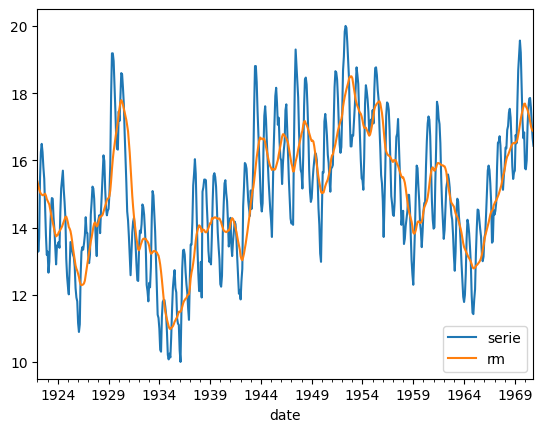

In [ ]:
ts = df['level']
rm_size = 12
show_tendencia(ts, rm_size)

*Gráfico 1*

Como já conhecido, a série 'lakeerie' possui uma sazonalidade de 12 meses.

1º teste de estacionariedade KPSS

In [ ]:
ts = df['level']

kpss = KPSSTest()
kpss.should_diff(ts)

(0.01, True)

O teste acusa que é necessária uma diferenciação para tornar a série estacionária

Plot da série diferenciada

<Axes: xlabel='date'>

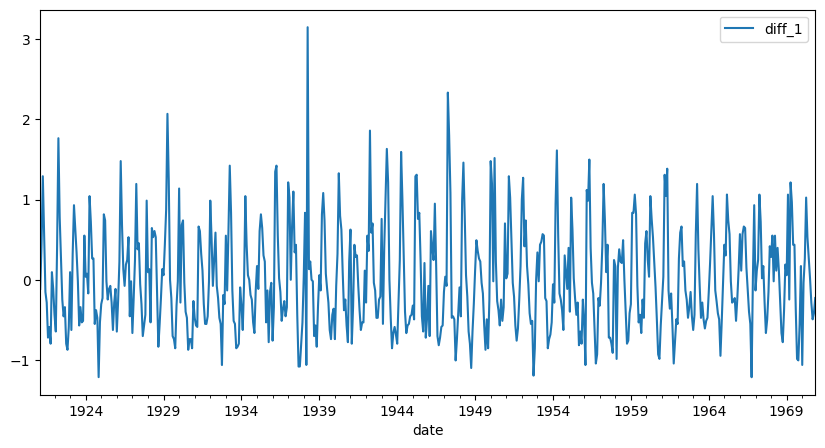

In [ ]:
df_diff = pd.DataFrame() # dataframe para armazenar os valores da série diferenciada
df_diff['diff_1'] = ts.diff().iloc[1:] # O método iloc[1:] é usado para descartar o primeiro elemento,
                                       # pois a primeira diferença não pode ser calculada para o primeiro elemento.
df_diff.plot(figsize=(10,5))

*Gráfico 2*

2º teste de estacionariedade KPSS

In [ ]:
ts = df_diff['diff_1']

kpss = KPSSTest()
kpss.should_diff(ts)

(0.1, False)

O teste indica que não é necessária uma nova diferenciação na série.

Plot das funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para a série lakeerie após a 1 diferenciação

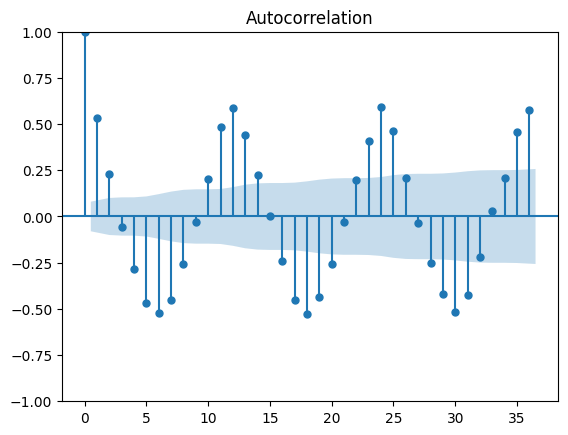

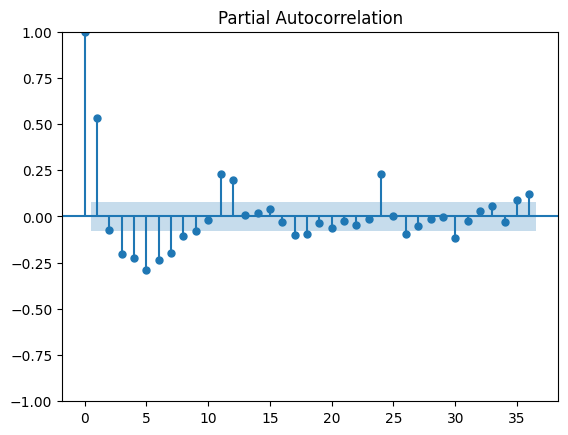

In [ ]:
ts = df_diff['diff_1']
plot_acf(ts, lags=36)
plt.show()
plot_pacf(ts, lags=36)
plt.show()

*Gráfico 3*

Após a diferenciação, a **sazonalidade** de 12 *lags* torna-se ainda mais pronunciada principalmente na **ACF**.

## Treinamento e métricas para a série 'lakeerie' (Modelo ARIMA)

Chamada da função para treinamento e teste

In [ ]:
# Parâmetros
test_size = 23 # 23 meses (últimos quase dois anos para da série para teste)
m = 12
horizon = 1 # queremos prever sempre o próximo dia ou próximo mês?
ts = df['level']

# Chamada da função para treinamento e predição
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1127.265, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=838.330, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=909.417, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1125.268, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=935.536, Time=0.13 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=754.614, Time=1.58 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=787.315, Time=1.62 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=756.563, Time=5.68 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=756.586, Time=3.60 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=758.660, Time=1.46 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=756.793, Time=4.09 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=

100%|██████████| 23/23 [00:07<00:00,  3.16it/s]


Gráficos de desempenho

<Axes: xlabel='date'>

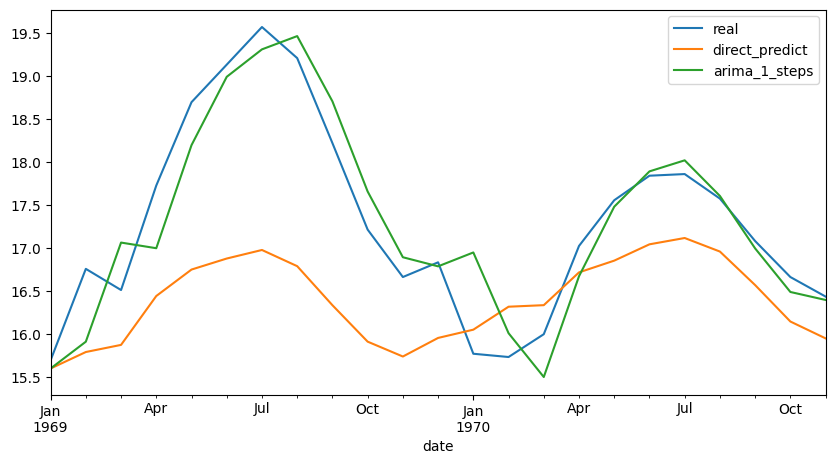

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot(figsize=(10,5))

Gráfico 4

Observa-se um desempenho visual interessante para o modelo ARIMA com horozonte 1. Nota-se também o péssimo desempenho do modelo para a predição direta dos últimos 23 meses da série.

Métricas de desempenho

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

In [ ]:
pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,1.509006,1.228416,5.595983,1.002129,20.874892,1.476688,82.608696,direct_predict
1,0.189230,0.435006,1.913980,0.325975,0.432651,0.156500,69.565217,arima_1_steps


Como esperado, a previsão de horizonte 1 supera a previsão direta em quase todas as métricas de desempenho, exceto na POCID (Prediction of Change in Direction), ficando com apróximadamene 70%. Ou seja, a previsão direta se saiu melhor em prever a mudança de direção da série com cerca de 82%.

## Treinamento e métricas para a série 'lakeerie' (Modelo MLPRegressor)

In [ ]:
# Parâmetros
test_size = 23
lag_size = 12
horizon = 1
ts = df['level']
model1 = MLPRegressor(solver = 'lbfgs') # 'solver' especifica o algoritmo a ser usado para otimizar os pesos da rede durante o treinamento
                                       # 'lbfgs' é frequentemente adequado para conjuntos de dados de tamanho pequeno a médio
model2 = MLPRegressor(solver='sgd', momentum=0.9, learning_rate_init=0.01, random_state=42)

# Chamada das funções para treinamento e predição
mlp_1step_diff_IBFGS = fit_predict_sklearn(test_size, lag_size, horizon,
                                     ts, model1, use_diff=True) # use_diff=True pois a série não é estacionária
                                                                # como verificado anteriormente
mlp_1step_diff_SGD = fit_predict_sklearn(test_size, lag_size, horizon,
                                     ts, model2, use_diff=True)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gráficos de desempenho

<Axes: xlabel='date'>

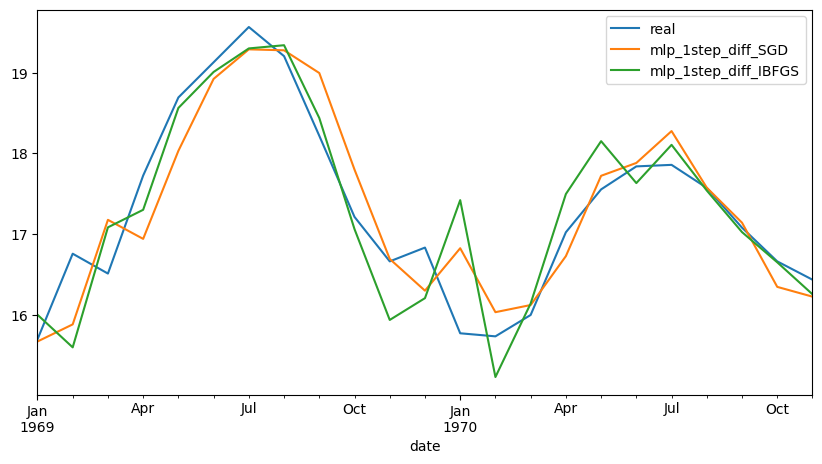

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'mlp_1step_diff_SGD': mlp_1step_diff_SGD,
        'mlp_1step_diff_IBFGS': mlp_1step_diff_IBFGS,
    }
)
df_result[['real', 'mlp_1step_diff_SGD', 'mlp_1step_diff_IBFGS']].plot(figsize=(10,5))

*Gráfico 5*

Métricas de desempenho

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['mlp_1step_diff_SGD', 'mlp_1step_diff_IBFGS']:

  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,0.229476,0.479037,2.150658,0.368998,0.499417,0.191650,78.260870,mlp_1step_diff_SGD
1,0.294681,0.542846,2.315693,0.388717,0.354759,0.221893,73.913043,mlp_1step_diff_IBFGS


Apesar de bem similares, o modelo com solver 'ibfgs' se saiu melhor em todas as métricas, exceto na POCID, ficando com aproximadamente 74% de acertividade na mudança de direção da série (cerca de 4% abaixo do modelo com solver 'sgd').

## Treinamento e métricas para a série 'lakeerie' (Modelo SVR)

In [ ]:
from sklearn.svm import SVR

test_size = 23
lag_size = 12
horizon = 1
ts = df['level']
model1 = SVR(C=100)
model2 = SVR(kernel='sigmoid', coef0=1, gamma='scale') # O kernel='sigmoid' é uma opção útil quando você espera que
                                                       # a relação entre as variáveis não siga uma tendência polinomial ou linear.

svr_1step_diff = fit_predict_sklearn(test_size, lag_size, horizon,
                                     ts, model1, use_diff=True)
svr_sig_1step_diff = fit_predict_sklearn(test_size, lag_size, horizon, ts, model2, use_diff=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gráficos de desempenho

<Axes: xlabel='date'>

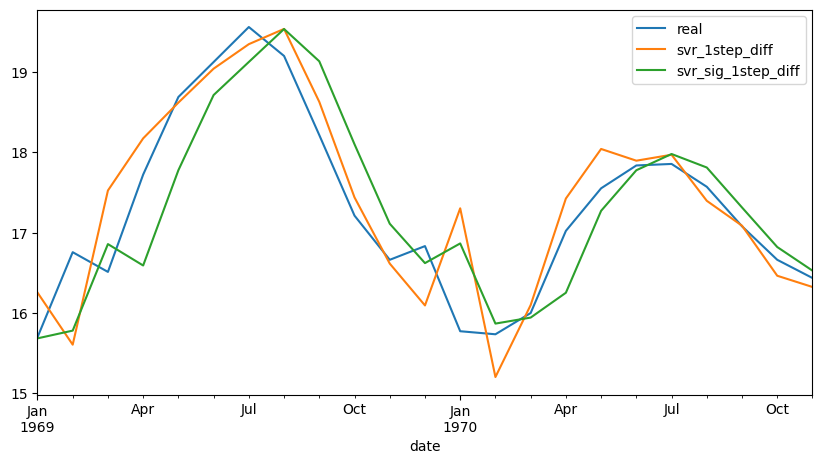

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'svr_1step_diff': svr_1step_diff,
        'svr_sig_1step_diff': svr_sig_1step_diff
    }
)
df_result[['real', 'svr_1step_diff', 'svr_sig_1step_diff']].plot(figsize=(10,5))

*Gráfico 6*

Métricas de desempenho

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['svr_1step_diff', 'svr_sig_1step_diff']:

  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,0.303148,0.550589,2.342154,0.393044,0.387960,0.221081,69.565217,svr_1step_diff
1,0.331266,0.575557,2.573962,0.447437,0.806645,0.274730,73.913043,svr_sig_1step_diff


O modelo SVR sem o kernel sigmoid performou melhor em quase todas as métricas, exceto na POCID (apesar desta métrica ter uma diferença de cerca de 4,4%).

## Conclusão

Gráficos gerais de desempenho

<Axes: xlabel='date'>

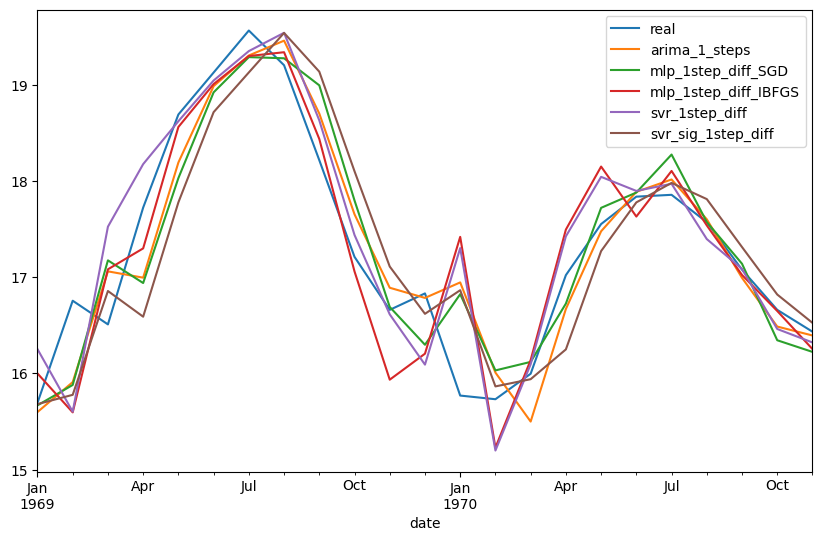

In [ ]:
df_result_final = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'arima_1_steps': prevs_h_steps,
        'mlp_1step_diff_SGD': mlp_1step_diff_SGD,
        'mlp_1step_diff_IBFGS': mlp_1step_diff_IBFGS,
        'svr_1step_diff': svr_1step_diff,
        'svr_sig_1step_diff': svr_sig_1step_diff
    }
)
df_result_final[['real', 'arima_1_steps', 'mlp_1step_diff_SGD', 'mlp_1step_diff_IBFGS', 'svr_1step_diff', 'svr_sig_1step_diff']].plot(figsize=(10,6))

*Gráfico 7*

Métricas gerais de desempenho

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results_final = []
for model_name in ['arima_1_steps', 'mlp_1step_diff_SGD', 'mlp_1step_diff_IBFGS',
                   'svr_1step_diff', 'svr_sig_1step_diff']:

  y_true = df_result_final['real']
  y_pred = df_result_final[model_name]
  dict_result_final = gerenerate_metric_results(y_true, y_pred)
  dict_result_final['model_name'] = model_name
  metric_results_final.append(dict_result_final)

pd.DataFrame(metric_results_final)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,0.189230,0.435006,1.913980,0.325975,0.432651,0.156500,69.565217,arima_1_steps
1,0.229476,0.479037,2.150658,0.368998,0.499417,0.191650,78.260870,mlp_1step_diff_SGD
2,0.294681,0.542846,2.315693,0.388717,0.354759,0.221893,73.913043,mlp_1step_diff_IBFGS
3,0.303148,0.550589,2.342154,0.393044,0.387960,0.221081,69.565217,svr_1step_diff
4,0.331266,0.575557,2.573962,0.447437,0.806645,0.274730,73.913043,svr_sig_1step_diff


Analisando os resultados consolidados, nota-se que o modelo **ARIMA** se destaca em grande parte das métricas, especialmente nas quatro primeiras (**MSE, RMSE, MAPE e MAE**) e na **ARV**. O modelo ARIMA registrou um valor de **0.432651** para a métrica **THEIL** e **69.565217** para o **POCID**, indicando um desempenho notável.

Ao examinar os resultados dos modelos de aprendizado de máquina, destaca-se o **MLPRegressor** com solver **ibfgs**, apresentando os melhores valores para as métricas **THEIL** e **POCID**, **0.354759** e **73.913043**, respectivamente. Determinar o modelo definitivo é desafiador, pois todos exibiram resultados bastante próximos. Contudo, é incontestável que o ARIMA parece ser o mais consistente em todas as métricas.